In [7]:
import sqlite3
import pandas as pd
import numpy as np
import sklearn
from sklearn import preprocessing
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import preprocessing
import missingno as msno
from sklearn.cluster import KMeans
'''
import plotly.plotly as py
import plotly.graph_objs as go
import plotly
from plotly.offline import init_notebook_mode
'''
import scipy
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.cluster import AgglomerativeClustering
import sklearn.metrics as sm
from sklearn.decomposition import PCA
from kmodes.kmodes import KModes
from sklearn.preprocessing import StandardScaler
from scipy.spatial import distance

pd.set_option('display.expand_frame_repr', False)

#******************************************************************************
#Import data
#******************************************************************************
# mac
#my_path = '/Users/Manita/Documents/DM/project/1_import and preprocess/insurance.db'

# windows
my_path = 'insurance.db'
#******************************************************************************
#SQL
#******************************************************************************

conn = sqlite3.connect(my_path)
cursor = conn.cursor()



In [108]:
# cluster frequency plot

def cluster_freq(table, column):
    print("\n")
    df = pd.DataFrame({"Absolute freq":table[column].value_counts(),
                       "Relative freq": np.round(table[column].value_counts()/len(table)*100,decimals=2)})
    print(df)
    plt.subplots(figsize=(7, 3))
    sns.countplot(x=table[column], data=table, palette="Oranges")
    sns.despine(left='False') 
    plt.show()
    
# 2 D clustering plot

def plot2d(table,x,y,hue=None):
    plt.figure(figsize=(15,7))
    plt.title ("Clusters", loc = "left",fontweight = "bold")
    sns.scatterplot(x=x, y=y, hue=hue,data=table, palette='Paired')
    plt.tick_params(labelsize=12)
    plt.xlabel(x,fontsize=12)
    plt.ylabel(y,fontsize=12)    
    plt.show()
    
    
# correlations
    
def corr(table):
    table = table.corr()
    mask = np.zeros_like(table)
    mask[np.triu_indices_from(mask)] = True
    with sns.axes_style("white"):
        plt.figure(figsize = (10,5))
        ax=sns.heatmap(table, 
                xticklabels=table.columns.values,
                yticklabels=table.columns.values,
                linewidths=0.1, annot= True,mask=mask,square=False)

    #plt.show()
    fig = ax.get_figure()
    fig.savefig('hist2.svg')
    
# k means elbow
 
def kmeans_elb(table, k):
    cluster_range = range(1,k+1)
    cluster_errors = []
    sse = {}
    for k in cluster_range:
        kmeans = KMeans(n_clusters=k, 
                    random_state=0,
                    n_init = 10,
                    max_iter = 300).fit(table)
        table["cluster"] = kmeans.labels_
        #print(data["clusters"])
        sse[k] = kmeans.inertia_
        cluster_errors.append(kmeans.inertia_)
        # Inertia: Sum of distances of samples to their closest cluster center
    plt.figure(figsize=(10,7))
    plt.plot(list(sse.keys()), list(sse.values()),
             linewidth=1.5,
             markeredgecolor="r",
             color = "black")
    plt.title ("Elbow Graph", loc = "left",fontweight = "bold")
    plt.xlabel("Number of cluster")
    plt.ylabel("SSE")
    plt.show()
    clusters_df = pd.DataFrame({"num_clusters":cluster_range,
                            "cluster_errors":cluster_errors})
    print (clusters_df)
    print("")
    print("Inertia:",np.round(kmeans.inertia_,decimals=2))
    
    
# dendogram
 
def dendo(table, method = 'ward', p = 40, line = 0):
    Z = linkage(table,
                method = 'ward')#method='single, complete
    plt.subplots(figsize=(8, 8))   
    dendrogram(Z,
               #truncate_mode='none',
               truncate_mode='lastp',
               p=p,
               orientation = 'top',
               leaf_rotation=45.,
               leaf_font_size=10.,
               show_contracted=True,
               show_leaf_counts=True)
        
    plt.title ("Truncated Hierarchical Clustering Dendrogram", loc = "left",fontweight = "bold")
    plt.axhline(y=line, color = "salmon", linestyle = "--")
    plt.xlabel('')
    plt.ylabel('Distance',fontsize=12)
    plt.gca().spines['right'].set_visible(False)
    plt.gca().spines['left'].set_visible(False)
    plt.gca().spines['top'].set_visible(False)
    plt.gca().spines['bottom'].set_visible(False)
    plt.tick_params(labelsize=12)
    plt.show()
    
    
# DONUT

def donut_plt(names,pop,table,nrow):
    group_names=names
    group_size=pop
    subgroup_names=names
    subgroup_size=table[nrow]
    # colors
    a, b, c,d,e=[plt.cm.Blues, plt.cm.Reds, plt.cm.Greens, plt.cm.Oranges, plt.cm.Greys] 
    # outside
    fig, ax = plt.subplots(figsize=(10,10))
    ax.axis('equal')
    mypie, _ = ax.pie(group_size, radius=1.3,textprops={'fontsize': 14},colors=[a(0.6), b(0.6), c(0.6),d(0.6),e(0.6)], wedgeprops = { 'linewidth' : 2, 'edgecolor' : 'white' } )
    plt.setp( mypie, width=0.3, edgecolor='white')
    
    # labels=group_names
    # Inside
    mypie2, _ = ax.pie(subgroup_size, radius=1.3-0.2, labeldistance=0.8, colors=[a(0.6), b(0.6), c(0.6),d(0.6),e(0.6)], wedgeprops = { 'linewidth' : 2, 'edgecolor' : 'white' })
    plt.setp( mypie2, width=0.4, edgecolor='white')
    plt.margins(0,0)
    plt.show()

In [9]:
sql = """select name from sqlite_master where type='table' order by name"""
cursor.execute(sql)
result = cursor.fetchall()
print(result)
print(type(result))

[('Engage',), ('LOB',)]
<class 'list'>


In [11]:
conn.close()

In [10]:
cursor.execute("select name from sqlite_master where type= 'table';")
print(cursor.fetchall())

lob_query= """select * from LOB"""
engage_query = """select * from Engage"""

#Tables
lob= pd.read_sql_query(lob_query, conn)
engage= pd.read_sql_query(engage_query, conn)

#******************************************************************************
#Rename columns
#******************************************************************************
#Lob
lob.rename(index = str, columns = {'Customer Identity':'c_id',
                                    'Premiums in LOB: Motor':'Motor',
                                    'Premiums in LOB: Household' : 'Household',
                                    'Premiums in LOB: Health':'Health',
                                    'Premiums in LOB:  Life':'Life',
                                    'Premiums in LOB: Work Compensations':'Work_compensate'},inplace = True )

#Engage
engage.rename(index = str, columns = {'Customer Identity':'c_id',
                                      'First Policy´s Year':'First_Policy_Year',
                                      'Brithday Year':'Birthday',
                                      'Educational Degree':'Educ',
                                      'Gross Monthly Salary':'Salary',
                                      'Geographic Living Area':'Living_Area',
                                      'Has Children (Y=1)':'Child',
                                      'Customer Monetary Value':'C_value',
                                      'Claims Rate':'Claims_rate'},inplace = True )

#******************************************************************************
#Set indexes
#******************************************************************************
'''
lob.c_id = lob.c_id-1
engage.c_id = engage.c_id-1
'''
#lob
#lob.set_index(keys='c_id',drop=True,inplace=True)
lob.drop(columns=['index'],inplace=True)
#engage
#engage.set_index(keys='c_id',drop=True,inplace=True)
engage.drop(columns=['index'],inplace=True)


[('LOB',), ('Engage',)]


In [12]:
lob.shape

(10296, 6)

In [13]:
lob.info()

<class 'pandas.core.frame.DataFrame'>
Index: 10296 entries, 0 to 10295
Data columns (total 6 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   c_id             10296 non-null  int64  
 1   Motor            10262 non-null  float64
 2   Household        10296 non-null  float64
 3   Health           10253 non-null  float64
 4   Life             10192 non-null  float64
 5   Work_compensate  10210 non-null  float64
dtypes: float64(5), int64(1)
memory usage: 563.1+ KB


In [14]:
engage.info()

<class 'pandas.core.frame.DataFrame'>
Index: 10296 entries, 0 to 10295
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   c_id               10296 non-null  int64  
 1   First_Policy_Year  10266 non-null  float64
 2   Birthday           10279 non-null  float64
 3   Educ               10279 non-null  object 
 4   Salary             10260 non-null  float64
 5   Living_Area        10295 non-null  float64
 6   Child              10275 non-null  float64
 7   C_value            10296 non-null  float64
 8   Claims_rate        10296 non-null  float64
dtypes: float64(7), int64(1), object(1)
memory usage: 804.4+ KB


In [15]:
#******************************************************************************
# Cleaning Data
#******************************************************************************
# Don't remove more than 3% of the data
#******************************************************************************
 
# MISSING DATA

# Join tables in a single df -> data

data = engage.merge(lob,on='c_id')

engage.describe()


,c_id,First_Policy_Year,Birthday,Salary,Living_Area,Child,C_value,Claims_rate
count,10296.00000,10266.000000,10279.000000,10260.000000,10295.000000,10275.000000,10296.000000,10296.000000
mean,5148.50000,1991.062634,1968.007783,2506.667057,2.709859,0.706764,177.892605,0.742772
std,2972.34352,511.267913,19.709476,1157.449634,1.266291,0.455268,1945.811505,2.916964
min,1.00000,1974.000000,1028.000000,333.000000,1.000000,0.000000,-165680.420000,0.000000
25%,2574.75000,1980.000000,1953.000000,1706.000000,1.000000,0.000000,-9.440000,0.390000
50%,5148.50000,1986.000000,1968.000000,2501.500000,3.000000,1.000000,186.870000,0.720000
75%,7722.25000,1992.000000,1983.000000,3290.250000,4.000000,1.000000,399.777500,0.980000
max,10296.00000,53784.000000,2001.000000,55215.000000,4.000000,1.000000,11875.890000,256.200000


In [16]:
data.describe()

,c_id,First_Policy_Year,Birthday,Salary,Living_Area,Child,C_value,Claims_rate,Motor,Household,Health,Life,Work_compensate
count,10296.00000,10266.000000,10279.000000,10260.000000,10295.000000,10275.000000,10296.000000,10296.000000,10262.000000,10296.000000,10253.000000,10192.000000,10210.000000
mean,5148.50000,1991.062634,1968.007783,2506.667057,2.709859,0.706764,177.892605,0.742772,300.470252,210.431192,171.580833,41.855782,41.277514
std,2972.34352,511.267913,19.709476,1157.449634,1.266291,0.455268,1945.811505,2.916964,211.914997,352.595984,296.405976,47.480632,51.513572
min,1.00000,1974.000000,1028.000000,333.000000,1.000000,0.000000,-165680.420000,0.000000,-4.110000,-75.000000,-2.110000,-7.000000,-12.000000
25%,2574.75000,1980.000000,1953.000000,1706.000000,1.000000,0.000000,-9.440000,0.390000,190.590000,49.450000,111.800000,9.890000,10.670000
50%,5148.50000,1986.000000,1968.000000,2501.500000,3.000000,1.000000,186.870000,0.720000,298.610000,132.800000,162.810000,25.560000,25.670000
75%,7722.25000,1992.000000,1983.000000,3290.250000,4.000000,1.000000,399.777500,0.980000,408.300000,290.050000,219.820000,57.790000,56.790000
max,10296.00000,53784.000000,2001.000000,55215.000000,4.000000,1.000000,11875.890000,256.200000,11604.420000,25048.800000,28272.000000,398.300000,1988.700000


In [17]:
data.to_csv("insurancedb.csv")

In [18]:
data.corr()

,c_id,First_Policy_Year,Birthday,Salary,Living_Area,Child,C_value,Claims_rate,Motor,Household,Health,Life,Work_compensate
c_id,1.000000,0.013598,0.008823,-0.009427,-0.005468,-0.002063,0.029437,-0.025403,-0.005235,0.022003,0.014400,0.011028,0.017045
First_Policy_Year,0.013598,1.000000,-0.010300,0.006808,-0.013397,-0.015502,0.000821,-0.001209,0.002314,-0.005597,0.000576,-0.003924,-0.004296
Birthday,0.008823,-0.010300,1.000000,-0.696189,-0.016567,0.439691,0.003498,0.004473,-0.157014,0.150434,0.003248,0.233701,0.208049
Salary,-0.009427,0.006808,-0.696189,1.000000,0.015385,-0.393768,-0.003256,-0.003510,0.135842,-0.133248,-0.002123,-0.196412,-0.174798
Living_Area,-0.005468,-0.013397,-0.016567,0.015385,1.000000,-0.021602,-0.005789,0.007498,0.000737,0.011035,0.003250,0.011742,0.003561
Child,-0.002063,-0.015502,0.439691,-0.393768,-0.021602,1.000000,-0.000928,-0.002202,0.155954,-0.063026,-0.065399,-0.116160,-0.085566
C_value,0.029437,0.000821,0.003498,-0.003256,-0.005789,-0.000928,1.000000,-0.992622,0.033655,0.032664,0.000953,0.010432,0.020290
Claims_rate,-0.025403,-0.001209,0.004473,-0.003510,0.007498,-0.002202,-0.992622,1.000000,-0.006459,-0.007958,0.006083,0.001081,-0.001468
Motor,-0.005235,0.002314,-0.157014,0.135842,0.000737,0.155954,0.033655,-0.006459,1.000000,-0.276720,-0.077721,-0.409424,-0.350368
Household,0.022003,-0.005597,0.150434,-0.133248,0.011035,-0.063026,0.032664,-0.007958,-0.276720,1.000000,0.024844,0.261867,0.240004


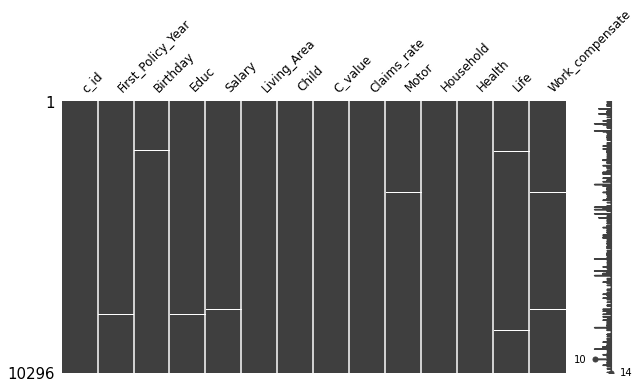

In [19]:
# Visualize missing values
#plt.style.use('dark_background')
#plt.style.use('seaborn-notebook')
msno.matrix(data,figsize=(10, 5),fontsize=12)
plt.show()

In [20]:
# Birthday
# 1997 rows where birthday is after the first year policy

len(data.loc[data['Birthday'] > data['First_Policy_Year']])

# remove birthday
data.drop(columns=['Birthday'],inplace=True)

# There is one client year equal to 53784.0
# remove it

data.loc[data['First_Policy_Year']>2000.0]
data.drop(index=9294,inplace=True)


In [21]:
# Fill Life and work compensate with mean

fill_life = np.mean(data.Life)
fill_work_comp = np.mean(data.Work_compensate)

data.loc[data.Life.isnull(),"Life"] = fill_life
data.loc[data.Work_compensate.isnull(),"Work_compensate"] = fill_work_comp

In [22]:
# number of deleteds
# add 1 for the first policy year error deleted (>2000)

n_del = np.sum(data.isnull().sum())+1
n_tot = len(data)

print(data.isnull().sum())

print("\nTotal data deleted:",
      n_del,
      "\n\nPercentage of data deleted:",
      np.round((len(data)-len(data.dropna()))/n_tot*100,decimals=2),"%")

data.dropna(inplace=True)

c_id                  0
First_Policy_Year    30
Educ                 17
Salary               36
Living_Area           1
Child                21
C_value               0
Claims_rate           0
Motor                34
Household             0
Health               43
Life                  0
Work_compensate       0
dtype: int64

Total data deleted: 183 

Percentage of data deleted: 1.32 %


In [23]:
#Split data df into lob and engage

lob = data.drop(columns=["First_Policy_Year",
              "Educ","Salary",
              "Living_Area",
              "Child",
              "C_value",
              "Claims_rate"])

engage = data.drop(columns=['Motor',
                           'Household',
                           'Health',
                           'Life',
                           'Work_compensate'])

In [24]:
#******************************************************************************
# Describe
#******************************************************************************

lob.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 10159 entries, 0 to 10295
Data columns (total 6 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   c_id             10159 non-null  int64  
 1   Motor            10159 non-null  float64
 2   Household        10159 non-null  float64
 3   Health           10159 non-null  float64
 4   Life             10159 non-null  float64
 5   Work_compensate  10159 non-null  float64
dtypes: float64(5), int64(1)
memory usage: 555.6 KB


In [25]:
engage.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10159 entries, 0 to 10295
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   c_id               10159 non-null  int64  
 1   First_Policy_Year  10159 non-null  float64
 2   Educ               10159 non-null  object 
 3   Salary             10159 non-null  float64
 4   Living_Area        10159 non-null  float64
 5   Child              10159 non-null  float64
 6   C_value            10159 non-null  float64
 7   Claims_rate        10159 non-null  float64
dtypes: float64(6), int64(1), object(1)
memory usage: 714.3+ KB


3 - BSc/MSc        46.67
2 - High School    34.20
1 - Basic          12.35
4 - PhD             6.78
Name: Educ, dtype: float64


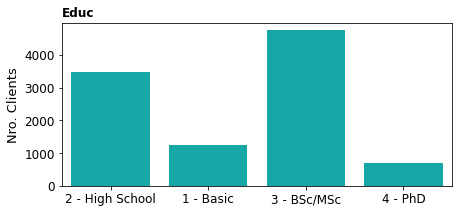

In [26]:
# Engage****************

# Educ
# Child
# Living_Area
variable="Educ"
print(np.round(engage[variable].value_counts()/len(engage)*100,decimals=2))
f, ax = plt.subplots(figsize=(7, 3))
sns.countplot(x=variable, data=engage, color="c")
plt.tick_params(labelsize=12)
plt.ylabel("Nro. Clients",fontsize = 13)
plt.xlabel("")
plt.title (variable, loc = "left",fontweight = "bold")
plt.show()

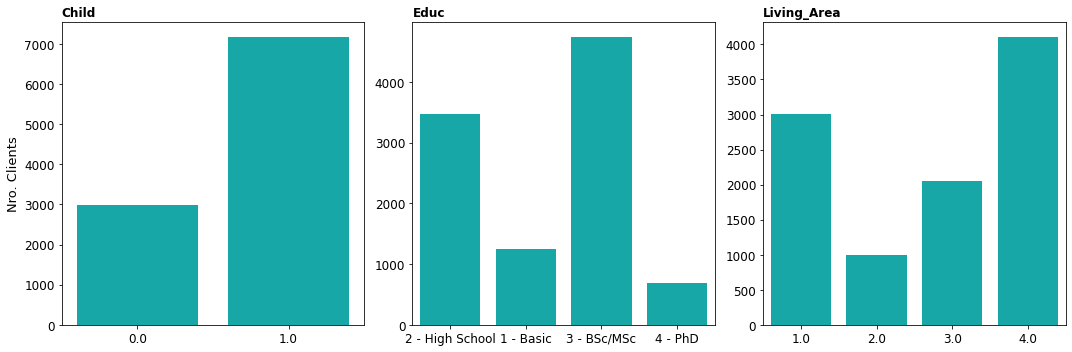

In [27]:
plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
sns.countplot(x='Child', data=engage, color="c")
plt.ylabel("Nro. Clients",fontsize = 13)
plt.tick_params(labelsize=12)
plt.xlabel("")
plt.title ('Child', loc = "left",fontweight = "bold")

plt.subplot(1,3, 2)
sns.countplot(x='Educ', data=engage, color="c")
plt.tick_params(labelsize=12)
plt.xlabel("")
plt.ylabel("")
plt.title ('Educ', loc = "left",fontweight = "bold")

plt.subplot(1, 3, 3)
sns.countplot(x='Living_Area', data=engage, color="c")
plt.tick_params(labelsize=12)
plt.xlabel("")
plt.ylabel("")
plt.title ('Living_Area', loc = "left",fontweight = "bold")
plt.tight_layout()
plt.show()

In [28]:
# Change Education
engage.loc[engage['Educ'] == '1 - Basic', 'Educ'] = 1.
engage.loc[engage['Educ'] == '2 - High School', 'Educ'] = 2.
engage.loc[engage['Educ'] == '3 - BSc/MSc', 'Educ'] = 3.
engage.loc[engage['Educ'] == '4 - PhD', 'Educ'] = 4.

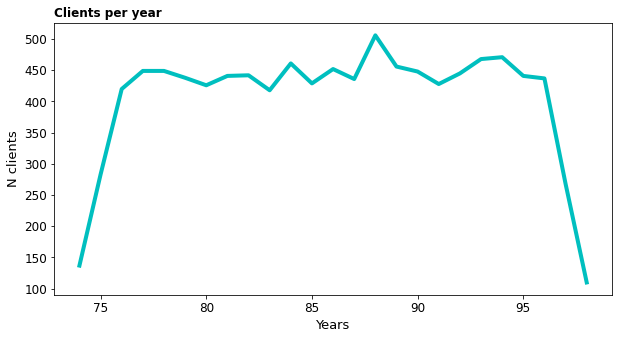

In [29]:
# Visualize Customers by year
policy_year=engage['First_Policy_Year'].value_counts()
policy_year.sort_index(inplace=True)

years = []
n_customers=[]
for item in policy_year.index.values:
    years.append(int(item)-1900)
for item in policy_year.values:
    n_customers.append(item)

cust_by_year = {'years': years, 'n_customers': n_customers}
cust_by_year = pd.DataFrame(data=cust_by_year)
cust_by_year.set_index("years",inplace=True)

plt.subplots(figsize=(10,5))
plt.xlabel("Years",fontsize = 13)
plt.ylabel("N clients", fontsize = 13)
plt.title ("Clients per year", loc = "left",fontweight = "bold")
plt.tick_params(labelsize=12)
plt.plot(cust_by_year,color="c",linewidth=4)
plt.show()

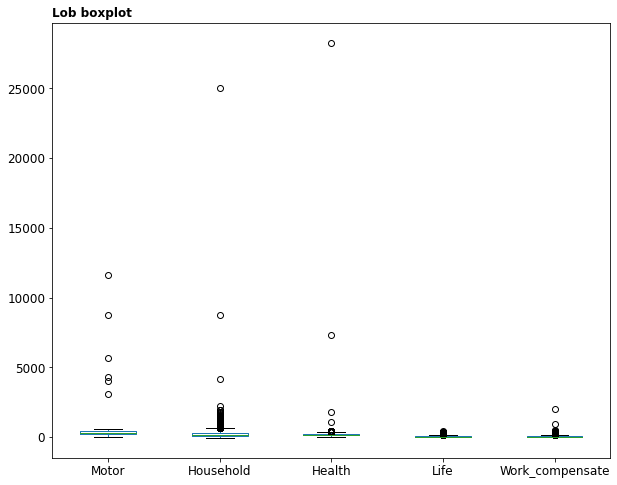

In [30]:
# lob****************

lob.drop(columns="c_id").boxplot(figsize=(10,8),grid=False)
plt.title ("Lob boxplot", loc = "left",fontweight = "bold")
plt.tick_params(labelsize=12)
plt.show()

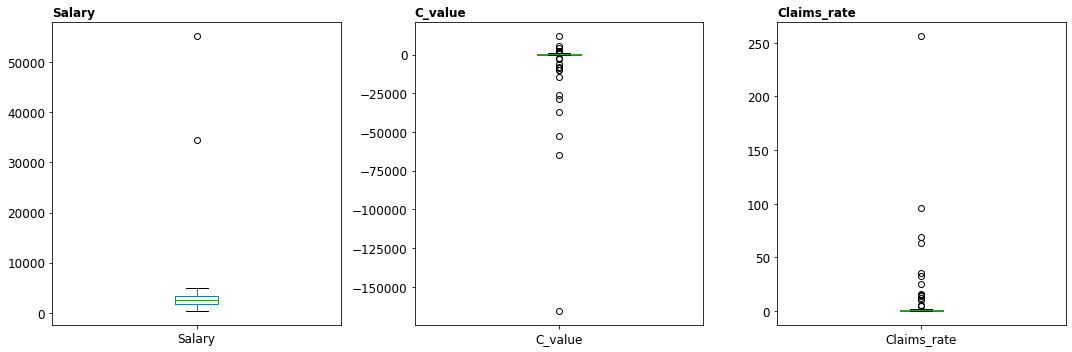

In [31]:
# Engage****************

plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
engage[['Salary']].boxplot(figsize=(10,8),grid=False)
plt.tick_params(labelsize=12)
plt.xlabel("")
plt.title ('Salary', loc = "left",fontweight = "bold")
#
plt.subplot(1, 3, 2)
engage[['C_value']].boxplot(figsize=(10,8),grid=False)
plt.tick_params(labelsize=12)
plt.xlabel("")
plt.title ('C_value', loc = "left",fontweight = "bold")

#
plt.subplot(1, 3, 3)
engage[['Claims_rate']].boxplot(figsize=(10,8),grid=False)
plt.tick_params(labelsize=12)
plt.xlabel("")
plt.title ('Claims_rate', loc = "left",fontweight = "bold")
plt.tight_layout()
plt.show()

C:\Users\lenovo\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Users\lenovo\anaconda3\lib\site-packages\seaborn\_core.py:1303: UserWarning: Vertical orientation ignored with only `x` specified.
  warnings.warn(single_var_warning.format("Vertical", "x"))


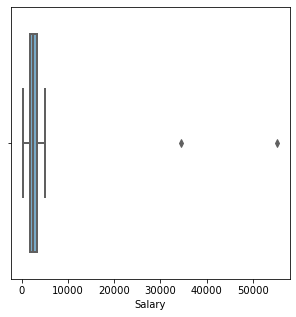

C:\Users\lenovo\anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\lenovo\anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\lenovo\anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-

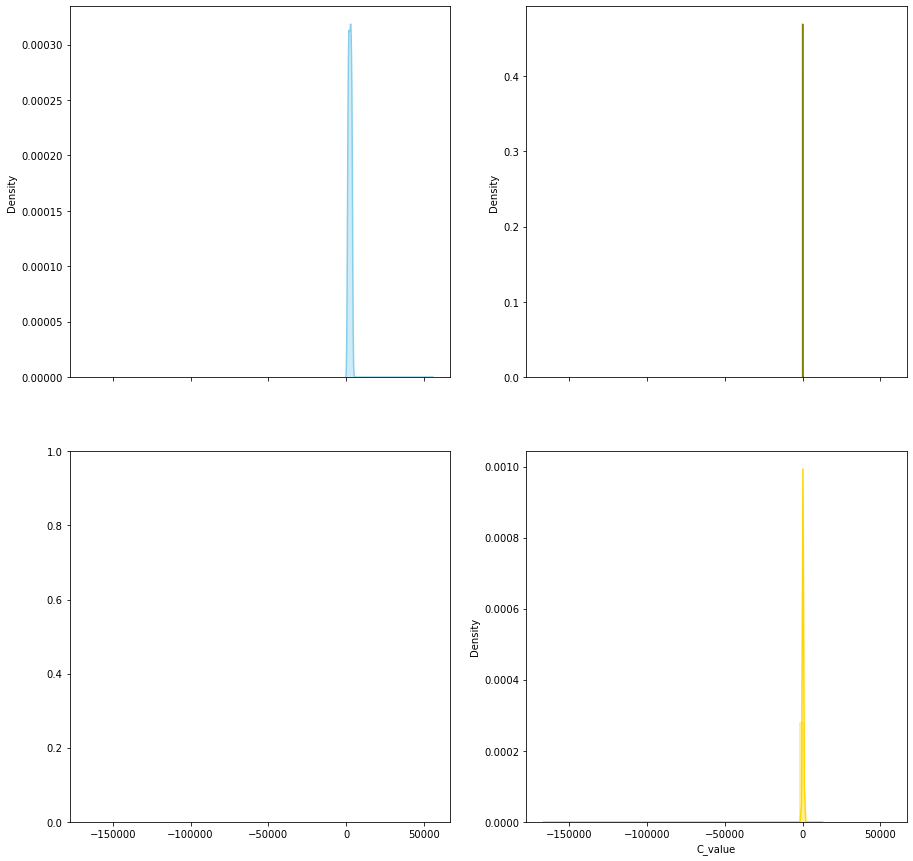

C:\Users\lenovo\anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


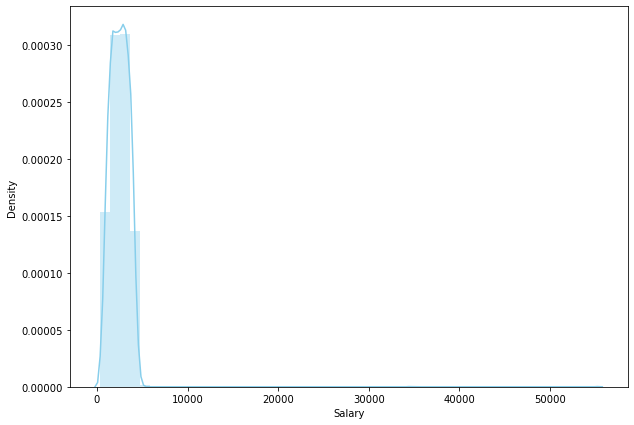

In [32]:
#******************************************************************************
# Outliers
#******************************************************************************

# engage

##########
#visualize
##########

# Total_Premium
# Salary
# C_value
# Claims_rate

variable= "Salary"
# boxplot**

plt.subplots(figsize=(5, 5))
sns.boxplot(engage[variable],orient="v",linewidth=2,palette="Blues")
plt.show()


f, axes = plt.subplots(2, 2, figsize=(15,15), sharex=True)
sns.distplot( engage["Salary"] , color="skyblue", ax=axes[0, 0])
sns.distplot( engage["Claims_rate"] , color="olive", ax=axes[0, 1])
sns.distplot( engage["C_value"] , color="gold", ax=axes[1, 1])
plt.show()

plt.subplots(figsize=(10, 7))
sns.distplot( engage.Salary , color="skyblue")
plt.show()

In [33]:
#Outliers ID

# c_value era -5000
outliers = list(engage.loc[engage["C_value"]<-2000]['c_id'])

outliers=np.append(outliers,
                   list(engage.loc[engage["Salary"]>20000]['c_id']))


outliers=np.append(outliers,
                   list(engage.loc[engage["Claims_rate"]>50]['c_id']))

C:\Users\lenovo\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Users\lenovo\anaconda3\lib\site-packages\seaborn\_core.py:1303: UserWarning: Vertical orientation ignored with only `x` specified.
  warnings.warn(single_var_warning.format("Vertical", "x"))


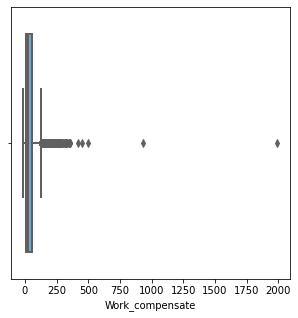

In [34]:
#lob

##########
#visualize
##########

#Motor
#Household
#Health
#Life
#Work_compensate

#boxplot**
variable= "Work_compensate"

plt.subplots(figsize=(5, 5))
sns.boxplot(lob[variable],orient="v",linewidth=2,palette="Blues")
plt.show()

In [35]:
# Outliers ID

outliers=np.append(outliers,
                   list(lob.loc[lob["Motor"]>2000]['c_id']))

outliers=np.append(outliers,
                   list(lob.loc[lob["Household"]>2000]['c_id']))

outliers=np.append(outliers,
                   list(lob.loc[lob["Health"]>5000]['c_id']))

'''
outliers=np.append(outliers,
                   lob.loc[lob["Life"]>375].index.values)
#rever life
'''
outliers=np.append(outliers,
                   list(lob.loc[lob["Work_compensate"]>750]['c_id']))



In [36]:
# Unique IDs
outliers = set(outliers)

len(outliers)


29

In [37]:
# set a df apart with outliers

lob_outliers = lob.copy()
engage_outliers = engage.copy()

lob_outliers = lob_outliers.loc[lob_outliers['c_id'].isin(outliers)]
engage_outliers = engage_outliers.loc[engage_outliers['c_id'].isin(outliers)]


# delete outliers

for outlier in outliers:
    engage = engage[engage.c_id != outlier]
    lob = lob[lob.c_id != outlier]
    n_del+= 1
  
print("\nTotal data deleted:",
      n_del,
      "\n\nPercentage of data deleted:",
      np.round(n_del/n_tot*100,decimals=2),"%")


Total data deleted: 212 

Percentage of data deleted: 2.06 %


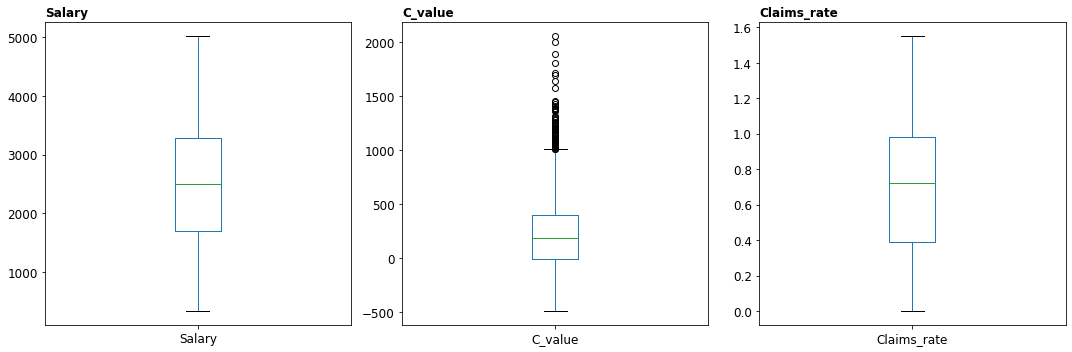

In [38]:
# after

plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
engage[['Salary']].boxplot(figsize=(10,8),grid=False)
plt.tick_params(labelsize=12)
plt.xlabel("")
plt.title ('Salary', loc = "left",fontweight = "bold")
#
plt.subplot(1, 3, 2)
engage[['C_value']].boxplot(figsize=(10,8),grid=False)
plt.tick_params(labelsize=12)
plt.xlabel("")
plt.title ('C_value', loc = "left",fontweight = "bold")

#
plt.subplot(1, 3, 3)
engage[['Claims_rate']].boxplot(figsize=(10,8),grid=False)
plt.tick_params(labelsize=12)
plt.xlabel("")
plt.title ('Claims_rate', loc = "left",fontweight = "bold")
plt.tight_layout()
plt.show()


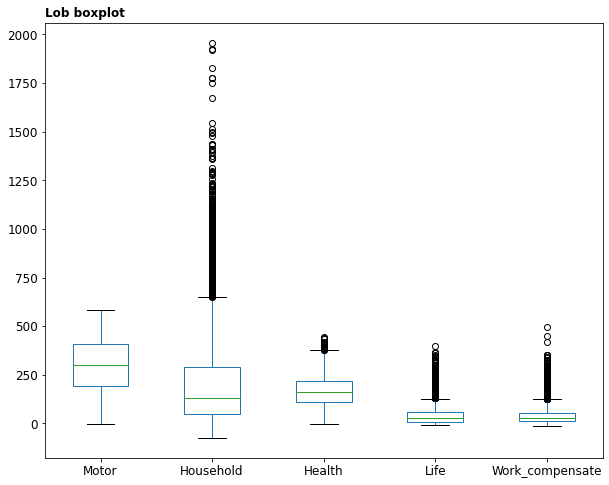

In [39]:
lob.drop(columns="c_id").boxplot(figsize=(10,8),grid=False)
plt.title ("Lob boxplot", loc = "left",fontweight = "bold")
plt.tick_params(labelsize=12)
plt.show()

In [40]:
#******************************************************************************
# Add New Variables
#******************************************************************************

#------
#Engage
#------

engage['Total_Premium'] = lob[['Motor','Household','Health','Life','Work_compensate']].sum(axis=1)
engage_outliers['Total_Premium'] = lob_outliers[['Motor','Household','Health','Life','Work_compensate']].sum(axis=1)


engage["High_Educ"]=0
engage_outliers["High_Educ"] = 0

engage.loc[(engage.Educ == 3.) | (engage.Educ == 4.), "High_Educ"] = 1.
engage_outliers.loc[(engage_outliers.Educ == 3.) | (engage_outliers.Educ == 4.), "High_Educ"] = 1.
# years as customer (2020 is the reference)

engage["years_as_cust"] = 2020. - engage["First_Policy_Year"]
engage_outliers["years_as_cust"] = 2020. - engage_outliers["First_Policy_Year"]

#data['R_salary_premiums'] = data['Salary']/data['Total_Premium']
#data['R_cvalue_crate'] = data['C_value']/data['Claims_rate']

engage.drop(columns=["Educ","First_Policy_Year"],inplace=True)
engage_outliers.drop(columns=["Educ","First_Policy_Year"],inplace=True)

In [41]:
#------
#lob
#------

lob['R_Motor'] = lob['Motor']/engage['Total_Premium']*100
lob['R_Household'] = lob['Household']/engage['Total_Premium']*100
lob['R_Health'] = lob['Health']/engage['Total_Premium']*100
lob['R_Life'] = lob['Life']/engage['Total_Premium']*100
lob['R_Work_compensate'] = lob['Work_compensate']/engage['Total_Premium']*100

lob_outliers['R_Motor'] = lob_outliers['Motor']/engage_outliers['Total_Premium']*100
lob_outliers['R_Household'] = lob_outliers['Household']/engage_outliers['Total_Premium']*100
lob_outliers['R_Health'] = lob_outliers['Health']/engage_outliers['Total_Premium']*100
lob_outliers['R_Life'] = lob_outliers['Life']/engage_outliers['Total_Premium']*100
lob_outliers['R_Work_compensate'] = lob_outliers['Work_compensate']/engage_outliers['Total_Premium']*100

# use ratios

lob.drop(columns=['Motor','Household','Health','Life','Work_compensate'],
             inplace=True)
lob_outliers.drop(columns=['Motor','Household','Health','Life','Work_compensate'],
             inplace=True)

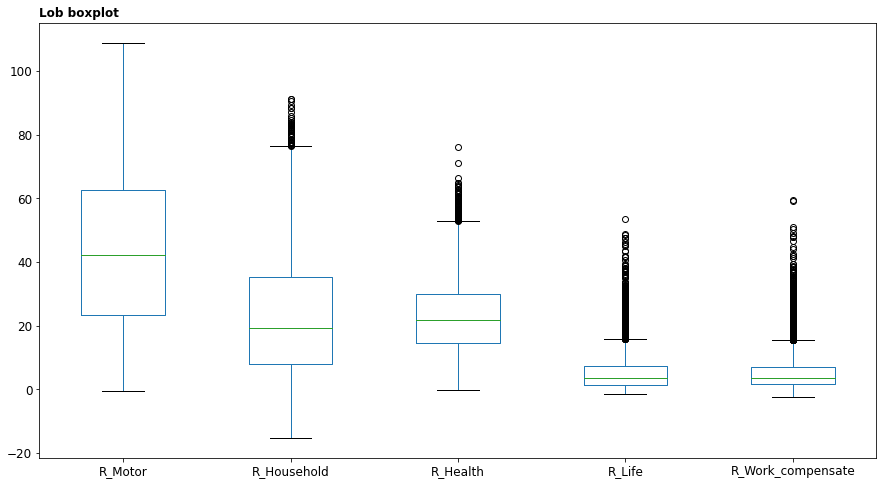

In [42]:
# check distribution

lob.drop(columns="c_id").boxplot(figsize=(15,8),grid=False)
plt.title ("Lob boxplot", loc = "left",fontweight = "bold")
plt.tick_params(labelsize=12)
plt.show()

In [43]:
# reset indexes

lob.reset_index(drop=True,inplace=True)
engage.reset_index(drop=True,inplace=True)

lob_outliers.reset_index(drop=True,inplace=True)
engage_outliers.reset_index(drop=True,inplace=True)

In [44]:
#******************************************************************************
#K-means
#******************************************************************************

# Correlations
lob.corr()


,c_id,R_Motor,R_Household,R_Health,R_Life,R_Work_compensate
c_id,1.000000,-0.015220,0.014920,-0.004937,0.008041,0.016014
R_Motor,-0.015220,1.000000,-0.798124,-0.290361,-0.522176,-0.514793
R_Household,0.014920,-0.798124,1.000000,-0.224275,0.219109,0.214613
R_Health,-0.004937,-0.290361,-0.224275,1.000000,0.072769,0.066827
R_Life,0.008041,-0.522176,0.219109,0.072769,1.000000,0.379713
R_Work_compensate,0.016014,-0.514793,0.214613,0.066827,0.379713,1.000000


,R_Motor,R_Health,R_Life,R_Work_compensate
count,1.013000e+04,1.013000e+04,1.013000e+04,1.013000e+04
mean,1.560888e-16,2.833370e-16,1.243274e-16,-1.461812e-16
std,1.000049e+00,1.000049e+00,1.000049e+00,1.000049e+00
min,-1.778719e+00,-2.149032e+00,-1.159599e+00,-1.319036e+00
25%,-8.195664e-01,-7.669201e-01,-6.658460e-01,-6.418789e-01
50%,-6.752886e-02,-1.163679e-01,-2.963951e-01,-2.806411e-01
75%,7.575291e-01,6.395383e-01,3.422749e-01,3.483372e-01
max,2.614587e+00,4.893170e+00,8.471523e+00,9.594834e+00


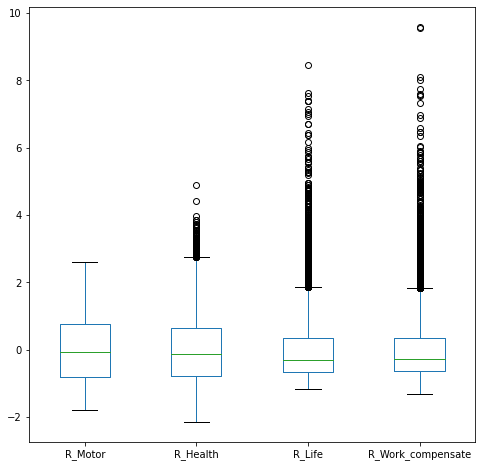

In [45]:

# Remove R_Household -> correlation with R_Motor= -0.8

lob_to_clust = lob.copy().drop(columns=['c_id','R_Household'])

# normalize lob 

my_scaler = preprocessing.StandardScaler() #StandardScaler
lob_to_clust = my_scaler.fit_transform(lob_to_clust)

lob_to_clust=pd.DataFrame(lob_to_clust, columns =  lob.copy().drop(columns=['c_id','R_Household']).columns)
########

lob_to_clust.boxplot(figsize=(8,8),grid=False)

lob_to_clust.describe()



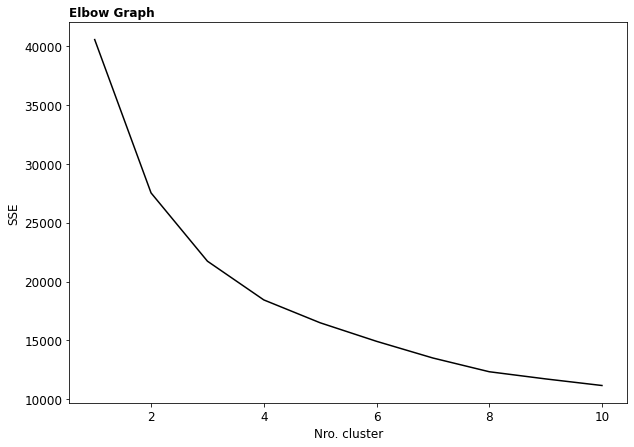


Inertia: 11181.69


In [46]:
# elbow graph
table = lob_to_clust
k=10
cluster_range = range(1,k+1)
cluster_errors = []
sse = {}
for k in cluster_range:
    kmeans = KMeans(n_clusters=k, 
                random_state=0,
                n_init = 10,
                max_iter = 300).fit(table)
    table["cluster"] = kmeans.labels_
    #print(data["clusters"])
    sse[k] = kmeans.inertia_
    cluster_errors.append(kmeans.inertia_)
    # Inertia: Sum of distances of samples to their closest cluster center
plt.figure(figsize=(10,7))
plt.plot(list(sse.keys()), list(sse.values()),
         linewidth=1.5,
         markeredgecolor="r",
         color = "black")
plt.title ("Elbow Graph", loc = "left",fontweight = "bold")
plt.xlabel("Nro. cluster", fontsize=12)
plt.ylabel("SSE", fontsize=12)
plt.tick_params(labelsize=12)
plt.show()


print("")
print("Inertia:",np.round(kmeans.inertia_,decimals=2))




In [47]:
# Check the clusters
lob_clustered = lob.copy().drop(columns=['R_Household'])
lob_clustered = pd.concat([lob_clustered,lob_to_clust.cluster],axis=1)

lob_clusters = pd.DataFrame(pd.DataFrame(lob_clustered.drop(columns="c_id").groupby('cluster').mean()))
print (lob_clusters)



           R_Motor   R_Health     R_Life  R_Work_compensate
cluster                                                    
0        18.695282  16.277981  10.308611           5.147590
1        62.059822  24.400775   2.228473           2.034854
2        81.288974  11.924274   1.245005           1.182522
3        29.709939  42.963963   5.802863           5.582045
4        20.394306  25.243547  11.271241          18.125144
5        16.894000  24.173644  25.565783           8.962094
6        49.389671  16.783700   3.626139           3.700462
7        18.562588  15.928353   4.981081          11.527843
8        36.074807  29.601542   4.454268           4.674204
9        12.130067  18.051901  15.954285          33.052276




   Absolute freq  Relative freq
8           2065          20.38
2           1752          17.30
1           1425          14.07
6           1154          11.39
3           1153          11.38
0           1068          10.54
7            747           7.37
4            364           3.59
5            291           2.87
9            111           1.10


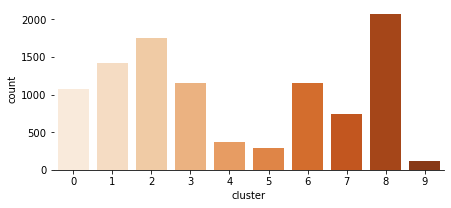

In [48]:
# Cluster frequency
cluster_freq(lob_to_clust,"cluster")




ValueError: Could not interpret value `R_Household` for parameter `y`

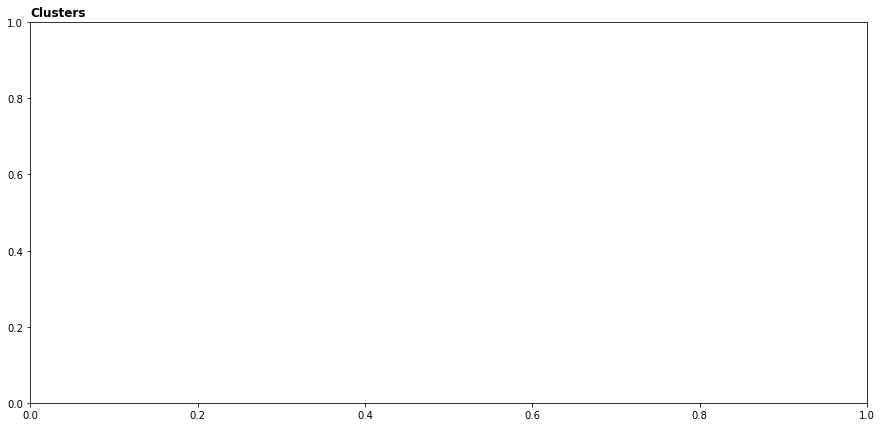

In [49]:

# visualize 

table = lob_clustered
x = "R_Motor"
y = "R_Household"
hue = "cluster"

plot2d(table,x,y,hue)

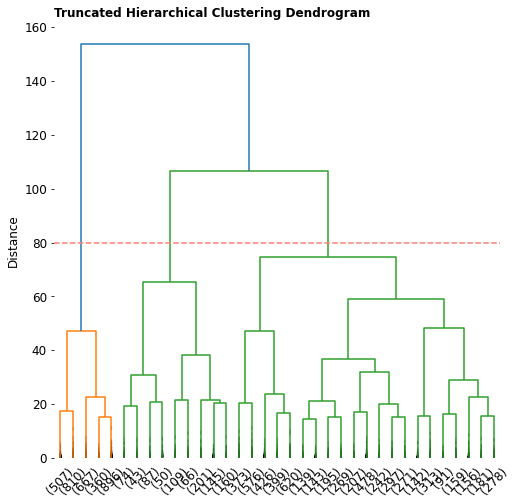

In [50]:
# normalize

lob_to_clust = lob.copy().drop(columns=['c_id','R_Household'])

# normalize lob 

my_scaler = preprocessing.StandardScaler() #StandardScaler #MinMaxScaler
lob_to_clust = my_scaler.fit_transform(lob_to_clust)

lob_to_clust=pd.DataFrame(lob_to_clust, columns =  lob.copy().drop(columns=['c_id','R_Household']).columns)



# Dendogram

dendo(lob_to_clust, line = 80, p =35)



In [51]:
# Hierarchical clustering理由截图在论文文件夹里

lob_to_clust = lob.copy().drop(columns=['c_id','R_Household'])

# normalize lob 

my_scaler = preprocessing.StandardScaler() #StandardScaler #MinMaxScaler
#my_scaler = preprocessing.MinMaxScaler() #StandardScaler #MinMaxScaler
lob_to_clust = my_scaler.fit_transform(lob_to_clust)

lob_to_clust=pd.DataFrame(lob_to_clust, columns =  lob.copy().drop(columns=['c_id','R_Household']).columns)


k=3

Hclustering = AgglomerativeClustering(n_clusters=k,
                                      affinity='euclidean',
                                      linkage='ward')

# Get clusters
my_HC = Hclustering.fit(lob_to_clust)

my_labels = pd.DataFrame(my_HC.labels_)
my_labels.columns =  ['lob_cluster']

# lob clustered
lob_clustered = lob.copy()
lob_clustered.reset_index(drop=True,inplace=True)


lob_clustered["cluster"] = my_labels


# lob clusters mean

lob_clusters = lob_clustered.groupby(['cluster']).mean()
print(lob_clusters)

lob_clusters.mean()

                c_id    R_Motor  R_Household   R_Health     R_Life  R_Work_compensate
cluster                                                                              
0        5170.879429  32.180871    29.262402  27.419204   5.301707           5.835816
1        5114.431790  72.663365     7.622485  16.305591   1.821616           1.586943
2        5198.602139  18.237208    33.084849  18.282657  17.112525          13.282761


c_id                 5161.304453
R_Motor                41.027148
R_Household            23.323245
R_Health               20.669151
R_Life                  8.078616
R_Work_compensate       6.901840
dtype: float64

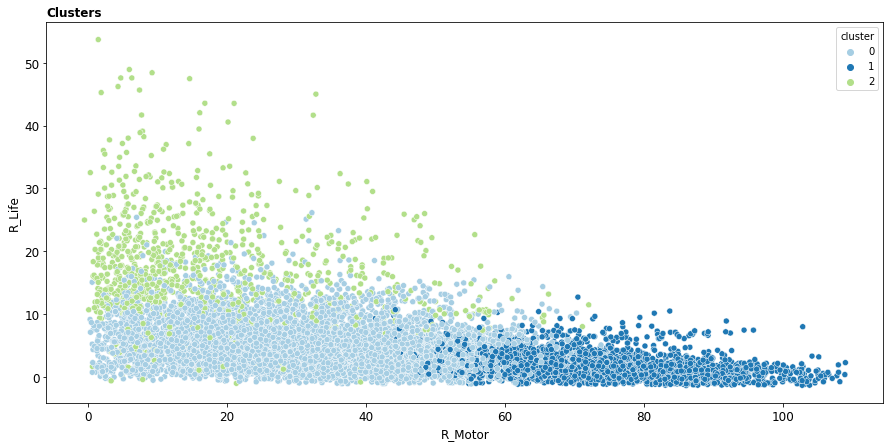

In [52]:
# visualize 

table = lob_clustered
x = "R_Motor"
y = "R_Life"
hue = "cluster"

plot2d(table,x,y,hue)

In [53]:
#没太搞明白在干嘛
lob_clustered.sort_values(by = 'cluster', inplace=True)


for value in lob_clustered.cluster.unique():
    lob_clusters.values[0]


count = 0

for index,centroid in lob_clustered[['R_Motor','R_Household','R_Health','R_Life','R_Work_compensate','cluster']].iterrows(): 
    if centroid.cluster==0:
        count +=1
    
print(count)   


zero = lob_clustered.loc[lob_clustered.cluster == 0]
zero = zero [['R_Motor','R_Health','R_Life','R_Work_compensate']]


##################


centro = lob_clusters[['R_Motor','R_Health','R_Life','R_Work_compensate']].values[0]
valores = zero.values

dist = 0
for value in valores:
  dist = dist + distance.euclidean(centro,value)

dist = np.round(dist,decimals=2)
print(dist)

5955
108095.53


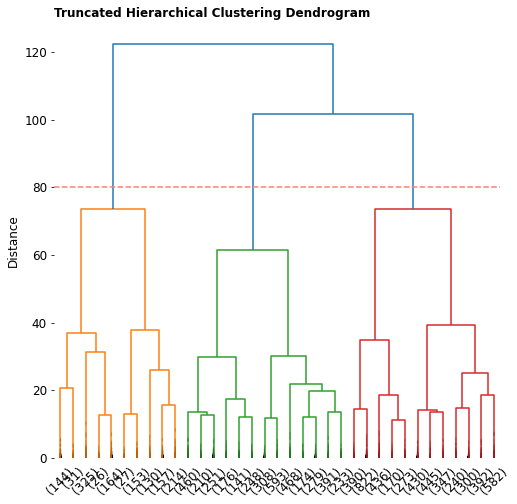

<ipython-input-54-d25d7709aa9b>:47: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  engage_clusters = engage_clustered.groupby(['cluster'])['Salary','C_value','Total_Premium'].mean()


              Salary     C_value  Total_Premium
cluster                                        
0        1921.698363  220.419099     686.762577
1        1883.688549  395.073071    1131.821245
2        3420.243388  156.591137     708.734978


   Absolute freq  Relative freq
0           4827          47.65
2           3932          38.82
1           1371          13.53


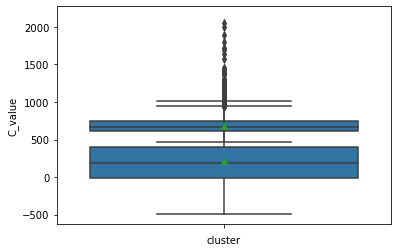

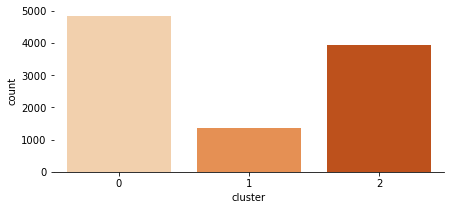

Inertia: 16419.9


   Absolute freq  Relative freq
0           4472          44.15
2           4396          43.40
1           1262          12.46


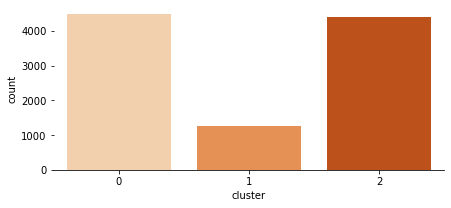

          Salary  C_value  Total_Premium  Claims_rate
cluster                                              
0        3391.25   210.31         711.49         0.66
1        1690.65   509.42        1125.58         0.51
2        1821.59   145.11         694.09         0.75


   Absolute freq  Relative freq
0           4472          44.15
2           4396          43.40
1           1262          12.46


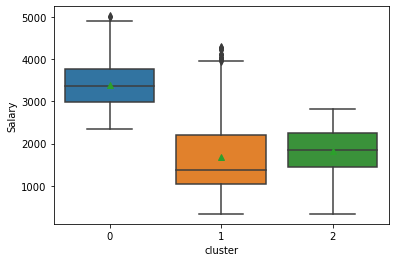

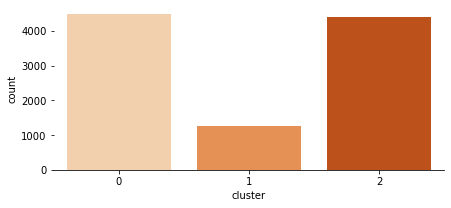

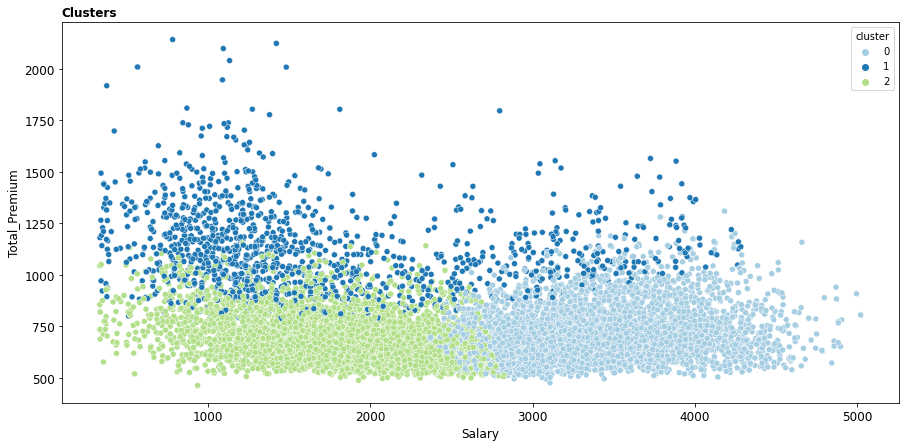

NameError: name 'go' is not defined

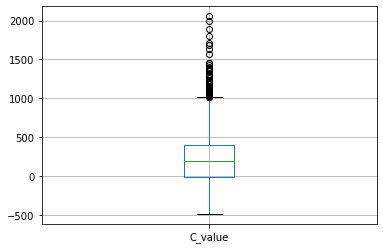

In [54]:
# Dendogram

engage_to_clust = engage.drop(columns=["c_id","Child","Claims_rate","Living_Area","High_Educ","years_as_cust"])


#******************************************************************************
# normalize
#******************************************************************************


my_scaler = preprocessing.StandardScaler() #StandardScaler MinMaxScaler
engage_to_clust = my_scaler.fit_transform(engage_to_clust)

# dendogram

dendo(engage_to_clust, line = 80, p =35)


#******************************************************************************
# Hierarchical
#******************************************************************************

engage_to_clust = engage.drop(columns=["c_id","Child","Claims_rate","Living_Area","High_Educ","years_as_cust"])
engage_to_clust = my_scaler.fit_transform(engage_to_clust)

k=3

Hclustering = AgglomerativeClustering(n_clusters=k,
                                      affinity='euclidean',
                                      linkage='ward')



# Get clusters
my_HC = Hclustering.fit(engage_to_clust)

my_labels = pd.DataFrame(my_HC.labels_)
my_labels.columns =  ['engage_cluster']

# Engage clustered
engage_clustered = my_scaler.inverse_transform(X=engage_to_clust)
engage_clustered = pd.concat([pd.DataFrame(engage_clustered), my_labels], axis=1)
engage_clustered.columns =  ['Salary','C_value','Total_Premium','cluster']

# Engage clusters mean

engage_clusters = engage_clustered.groupby(['cluster'])['Salary','C_value','Total_Premium'].mean()
print(engage_clusters)

engage_clustered.mean()


'''boxplot compare distributions'''
variable = 'Total_Premium'

sns.boxplot (y = variable, x = "cluster", data =engage_clustered ,showmeans=True)

sns.boxplot (y = "C_value", data =engage_clustered ,showmeans=True, orient = 'v' )


# Cluster frequency

cluster_freq(engage_clustered,"cluster")

# centroids

engage_clusters
init_centroids=engage_clusters.copy().values


#******************************************************************************
# K means
#******************************************************************************


# elbow graph

engage_to_clust = engage[['Salary','C_value','Total_Premium']].copy()
my_scaler = preprocessing.StandardScaler()
engage_to_clust = my_scaler.fit_transform(engage_to_clust)
engage_to_clust = pd.DataFrame(engage_to_clust, columns = ['Salary','C_value','Total_Premium'])

table = engage_to_clust
k = 3

sse = {}
kmeans = KMeans(n_clusters=k, 
            random_state=0,
            n_init = 1,
            init=init_centroids,
            max_iter = 500).fit(table)
table["cluster"] = kmeans.labels_


print("Inertia:",np.round(kmeans.inertia_,decimals=2))



engage_clustered = my_scaler.inverse_transform(X=engage_to_clust.drop(columns="cluster"))
engage_clustered = pd.DataFrame(engage_clustered, columns = ['Salary','C_value','Total_Premium'])
engage_clustered["cluster"] = engage_to_clust["cluster"]

# add claims rate

engage_clustered['Claims_rate'] = engage.Claims_rate

cluster_freq(engage_clustered,"cluster")
engage_clusters = pd.DataFrame(pd.DataFrame(engage_clustered.groupby('cluster').mean()))
print (np.round(engage_clusters,decimals=2))

engage_clusters.mean()

'''
# see best cluster method: hier or k means with hier
zero = engage_clustered.loc[engage_clustered.cluster == 0]
zero = zero [['Salary','C_value','Total_Premium']]
centro = engage_clusters[['Salary','C_value','Total_Premium']].values[0]
valores = zero.values
dist = 0
for value in valores:
  dist = dist + distance.euclidean(centro,value)
dist = np.round(dist,decimals=2)
print(dist)
'''

variable = 'Salary'

sns.boxplot (y = variable, x = "cluster", data =engage_clustered ,showmeans=True)



# Cluster frequency

cluster_freq(engage_clustered,"cluster")


# visualize 

table = engage_clustered
x = "Salary"
y = "Total_Premium"
hue = "cluster"

plot2d(table,x,y,hue)


engage_clustered.boxplot(column=['C_value'])



#K-Means 3D

table = engage_clustered
z = "Total_Premium"
y = "C_value"
x = "Salary"

x = table[x]
y = table[y]
z = table[z]
c = "cluster"

c = table[c]


trace1 = go.Scatter3d(
    x=x,
    y=y,
    z=z,
    mode='markers',
    marker=dict(
        size=12,
        color=c,
        colorscale = 'Viridis',
        opacity=0.8
        
    )
)

data = [trace1]
layout = go.Layout(
    margin=dict(
        l=0,
        r=0,
        b=0,
        t=0
    )
)

fig = go.Figure(data=data, layout=layout)

plotly.offline.plot(fig)

In [ ]:
df = pd.DataFrame(columns=["c_id"])
df.c_id = engage.c_id
#df.set_index("c_id",drop=True,inplace=True)

#kmode_label = pd.read_csv('/Users/Manita/OneDrive - NOVAIMS/DM/project/3_engage/kmodes.csv',sep=',')
kmode_label = pd.read_csv('kmodes.csv',sep=',')
df['kmode_cluster']=kmode_label.kmode_cluster

df = pd.concat([df,engage_clustered.cluster],axis=1)
df.columns = ["c_id","kmode_cluster","engage_cluster"]

#teste = engage[['Child','High_Educ','Living_Area']]

#teste['kmode'] = df.kmode_cluster

#teste.groupby(['kmode']).apply(pd.DataFrame.mode).reset_index(drop=True)


# give names to clusters

# engage
df['engage_cluster'].replace(to_replace=0, value='Wealthier', inplace=True)
df['engage_cluster'].replace(to_replace=1, value='Most_valuable', inplace=True)
df['engage_cluster'].replace(to_replace=2, value='Less_valuable', inplace=True)

# kmodes
df['kmode_cluster'].replace(to_replace=0, value='high_educ_la1', inplace=True)
df['kmode_cluster'].replace(to_replace=1, value='high_child', inplace=True)
df['kmode_cluster'].replace(to_replace=2, value='low_educ_child', inplace=True)



print(df.groupby(['engage_cluster']).size())
print(df.groupby(['engage_cluster','kmode_cluster']).size())


c1 = pd.DataFrame({'count' : df.groupby( [ "engage_cluster"] ).size()}).reset_index()
c2 = pd.DataFrame({'count' : df.groupby( [ "engage_cluster", "kmode_cluster"] ).size()}).reset_index()

c1_count = c1['count'].values

    
to_divide = pd.DataFrame({'to_divide':np.column_stack((c1_count, c1_count,c1_count)).flatten()})


c2 = pd.concat([c2,to_divide],axis=1)


# table with percentage of each k mode cluster in engage clusters
c2['kmode_freq'] = np.round(np.divide(c2['count'].values,c2.to_divide)*100,decimals = 1)

print(c2)



crosstable =pd.crosstab(df['engage_cluster'], df['kmode_cluster']).apply(lambda r: r/r.sum(), axis=1)

crosstable.plot.bar(figsize=(10, 7),colormap="Oranges",edgecolor = "black",linewidth = 1,rot=0)
#plt.legend() -> array com nomes dos clusters
plt.legend(title = "Kmode cluster",loc = 0)
plt.title ("Describing Engage", loc = "left",fontweight = "bold")
plt.ylabel("Nro. Clients", fontsize = 12)
plt.tick_params(labelsize=12)
plt.show()





In [ ]:
X = data.iloc[:, 8:].values
y = data.iloc[:, 6].values

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [117]:
from sklearn.ensemble import RandomForestRegressor

regressor = RandomForestRegressor(n_estimators=20, random_state=0)
regressor.fit(X_train, y_train)
y_pred = regressor.predict(X_test)

In [118]:
sklearn.metrics.r2_score(y_test, y_pred)

-0.04044340645911948

In [105]:
df = pd.read_csv('WA_Fn-UseC_-Marketing-Customer-Value-Analysis.csv')

In [56]:
# Identifying Outliers with Interquartile Range (IQR)
Q1 = df['Customer Lifetime Value'].quantile(0.25)
Q3 = df['Customer Lifetime Value'].quantile(0.75)
IQR = Q3 - Q1
print(IQR)

4967.915247000001


In [57]:
Q3 + 1.5 * IQR

16414.039911750002

In [106]:
df = pd.read_csv('WA_Fn-UseC_-Marketing-Customer-Value-Analysis.csv')

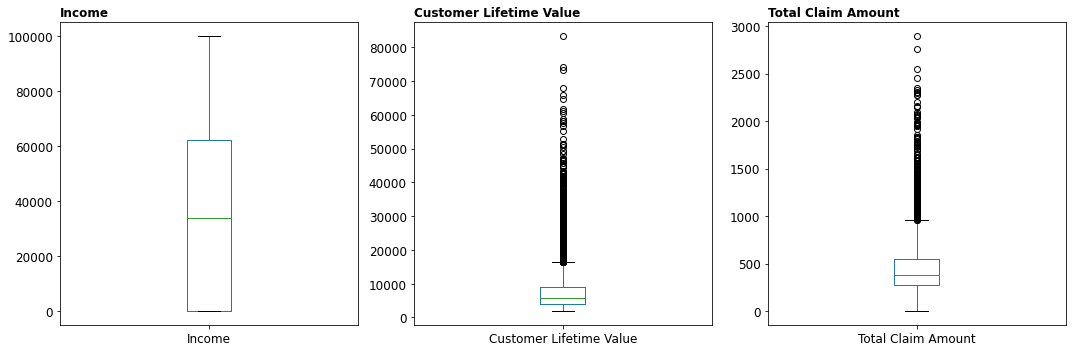

In [59]:
plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
df[['Income']].boxplot(figsize=(10,8),grid=False)
plt.tick_params(labelsize=12)
plt.xlabel("")
plt.title ('Income', loc = "left",fontweight = "bold")
#
plt.subplot(1, 3, 2)
df[['Customer Lifetime Value']].boxplot(figsize=(10,8),grid=False)
plt.tick_params(labelsize=12)
plt.xlabel("")
plt.title ('Customer Lifetime Value', loc = "left",fontweight = "bold")

#
plt.subplot(1, 3, 3)
df[['Total Claim Amount']].boxplot(figsize=(10,8),grid=False)
plt.tick_params(labelsize=12)
plt.xlabel("")
plt.title ('Total Claim Amount', loc = "left",fontweight = "bold")
plt.tight_layout()
plt.savefig('boxplot.pdf', bbox_inches='tight')
plt.show()

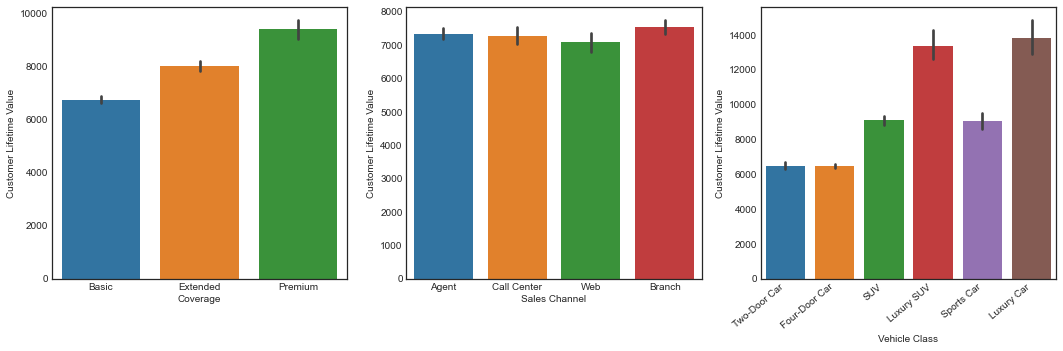

In [103]:
plt.figure(figsize=(18,5))
plt.subplot(1, 3, 1)
sns.barplot(x='Coverage', y='Customer Lifetime Value', data=df)
plt.subplot(1, 3, 2)
sns.barplot(x='Sales Channel', y='Customer Lifetime Value', data=df)
plt.subplot(1, 3, 3)
ax = sns.barplot(x='Vehicle Class', y='Customer Lifetime Value', data=df)
ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right")
fig = ax.get_figure()
fig.savefig('hist0.svg')

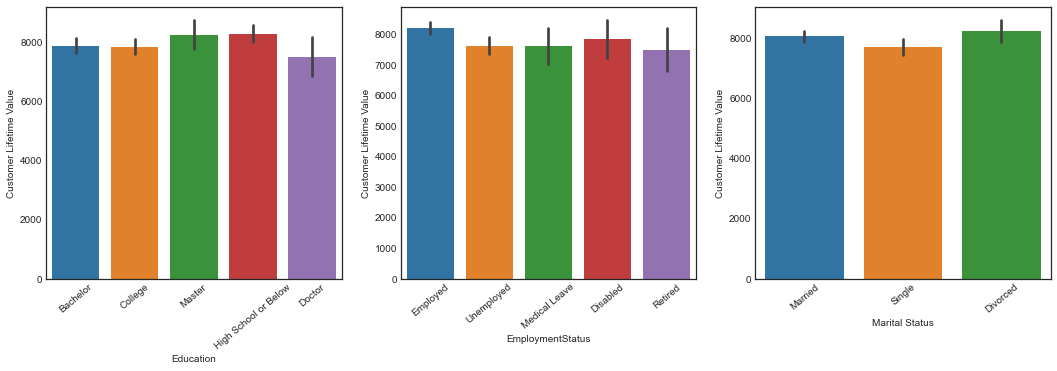

In [110]:
plt.figure(figsize=(18,5))
plt.subplot(1, 3, 1)
plt.xticks(rotation=40)
sns.barplot(x='Education', y='Customer Lifetime Value', data=df)

plt.subplot(1, 3, 2)
plt.xticks(rotation=40)
sns.barplot(x='EmploymentStatus', y='Customer Lifetime Value', data=df)
plt.subplot(1, 3, 3)
plt.xticks(rotation=40)
ax = sns.barplot(x='Marital Status', y='Customer Lifetime Value', data=df)
fig = ax.get_figure()
fig.savefig('hist1.svg')

In [62]:
outliers = []
outliers=np.append(outliers,
                   list(df.loc[df['Customer Lifetime Value']>30000]['Customer']))

outliers=np.append(outliers,
                   list(df.loc[df["Total Claim Amount"]>2000]['Customer']))

In [63]:
len(outliers)

208

In [64]:
df_outliers = df.copy()

df_outliers = df_outliers.loc[df_outliers['Customer'].isin(outliers)]

n_del=1
# delete outliers

for outlier in outliers:
    df = df[df.Customer != outlier]
    n_del+= 1
  
print("\nTotal data deleted:",
      n_del,
      "\n\nPercentage of data deleted:",
      np.round(n_del/9134*100,decimals=2),"%")


Total data deleted: 209 

Percentage of data deleted: 2.29 %


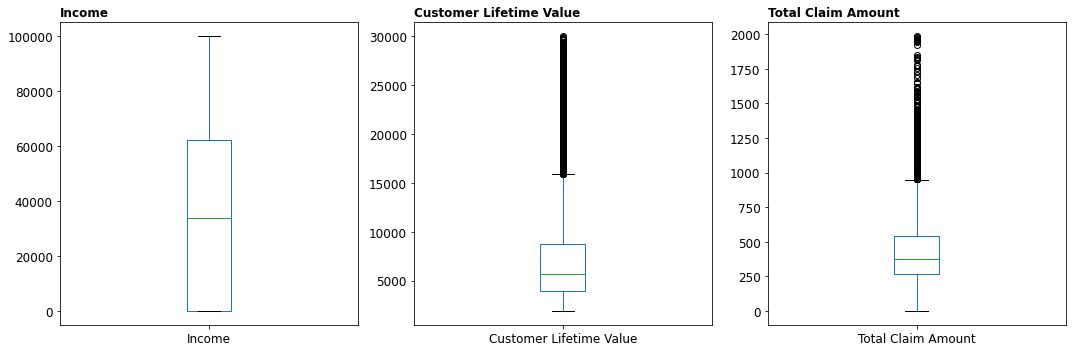

In [65]:
plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
df[['Income']].boxplot(figsize=(10,8),grid=False)
plt.tick_params(labelsize=12)
plt.xlabel("")
plt.title ('Income', loc = "left",fontweight = "bold")
#
plt.subplot(1, 3, 2)
df[['Customer Lifetime Value']].boxplot(figsize=(10,8),grid=False)
plt.tick_params(labelsize=12)
plt.xlabel("")
plt.title ('Customer Lifetime Value', loc = "left",fontweight = "bold")

#
plt.subplot(1, 3, 3)
df[['Total Claim Amount']].boxplot(figsize=(10,8),grid=False)
plt.tick_params(labelsize=12)
plt.xlabel("")
plt.title ('Total Claim Amount', loc = "left",fontweight = "bold")
plt.tight_layout()
plt.savefig('boxplot2.pdf', bbox_inches='tight')
plt.show()

In [66]:
df.shape

(8929, 24)

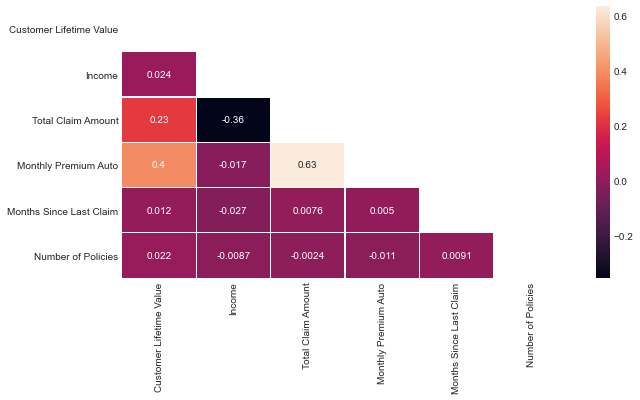

In [109]:
corr(df[['Customer Lifetime Value','Income','Total Claim Amount','Monthly Premium Auto','Months Since Last Claim','Number of Policies']])

         Customer Lifetime Value        Income  Total Claim Amount
cluster                                                           
0                    6159.421146  17916.420322          549.000611
1                    5408.145519  64400.932457          246.687138
2                   17818.185997  39279.158929          452.561621


   Absolute freq  Relative freq
0           4537          50.81
1           3272          36.64
2           1120          12.54


<ipython-input-68-b2778759dacd>:30: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  engage_clusters = engage_clustered.groupby(['cluster'])['Customer Lifetime Value','Income','Total Claim Amount'].mean()


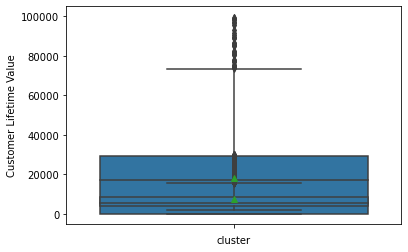

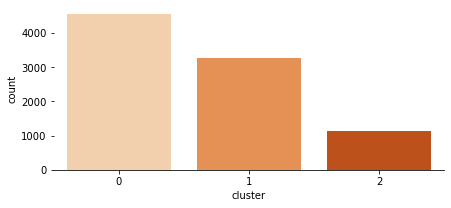

Inertia: 13362.78


   Absolute freq  Relative freq
2           3995          44.74
1           3761          42.12
0           1173          13.14


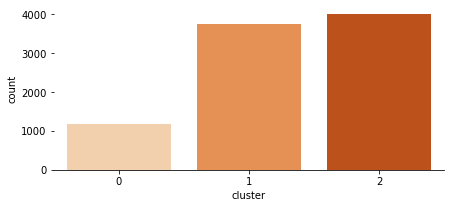

         Customer Lifetime Value    Income  Total Claim Amount
cluster                                                       
0                       17795.53  33160.87              627.37
1                        6010.35  64485.21              268.88
2                        5536.43  13660.25              515.06


Customer Lifetime Value     9780.768835
Income                     37102.113199
Total Claim Amount           470.438712
dtype: float64

In [68]:

engage = df[['Customer Lifetime Value','Income','Total Claim Amount']]
#******************************************************************************
# Hierarchical
#******************************************************************************

engage_to_clust = engage
engage_to_clust = my_scaler.fit_transform(engage_to_clust)

k=3

Hclustering = AgglomerativeClustering(n_clusters=k,
                                      affinity='euclidean',
                                      linkage='ward')



# Get clusters
my_HC = Hclustering.fit(engage_to_clust)

my_labels = pd.DataFrame(my_HC.labels_)
my_labels.columns =  ['engage_cluster']

# Engage clustered
engage_clustered = my_scaler.inverse_transform(X=engage_to_clust)
engage_clustered = pd.concat([pd.DataFrame(engage_clustered), my_labels], axis=1)
engage_clustered.columns =  ['Customer Lifetime Value','Income','Total Claim Amount','cluster']

# Engage clusters mean

engage_clusters = engage_clustered.groupby(['cluster'])['Customer Lifetime Value','Income','Total Claim Amount'].mean()
print(engage_clusters)

engage_clustered.mean()


'''boxplot compare distributions'''
variable = 'Income'

sns.boxplot (y = variable, x = "cluster", data =engage_clustered ,showmeans=True)

sns.boxplot (y = "Customer Lifetime Value", data =engage_clustered ,showmeans=True, orient = 'v' )


# Cluster frequency

cluster_freq(engage_clustered,"cluster")

# centroids

engage_clusters
init_centroids=engage_clusters.copy().values

#******************************************************************************
# K means
#******************************************************************************


# elbow graph

engage_to_clust = engage.copy()
my_scaler = preprocessing.StandardScaler()
engage_to_clust = my_scaler.fit_transform(engage_to_clust)
engage_to_clust = pd.DataFrame(engage_to_clust, columns = ['Customer Lifetime Value','Income','Total Claim Amount'])

table = engage_to_clust
k = 3

sse = {}
kmeans = KMeans(n_clusters=k, 
            random_state=0,
            n_init = 1,
            init=init_centroids,
            max_iter = 500).fit(table)
table["cluster"] = kmeans.labels_


print("Inertia:",np.round(kmeans.inertia_,decimals=2))



engage_clustered = my_scaler.inverse_transform(X=engage_to_clust.drop(columns="cluster"))
engage_clustered = pd.DataFrame(engage_clustered, columns = ['Customer Lifetime Value','Income','Total Claim Amount'])
engage_clustered["cluster"] = engage_to_clust["cluster"]

# add claims rate

#engage_clustered['Claims_rate'] = engage.Claims_rate

cluster_freq(engage_clustered,"cluster")
engage_clusters = pd.DataFrame(pd.DataFrame(engage_clustered.groupby('cluster').mean()))
print (np.round(engage_clusters,decimals=2))

engage_clusters.mean()

In [69]:
np.round(engage_clusters,decimals=2).to_csv("clu1.csv")

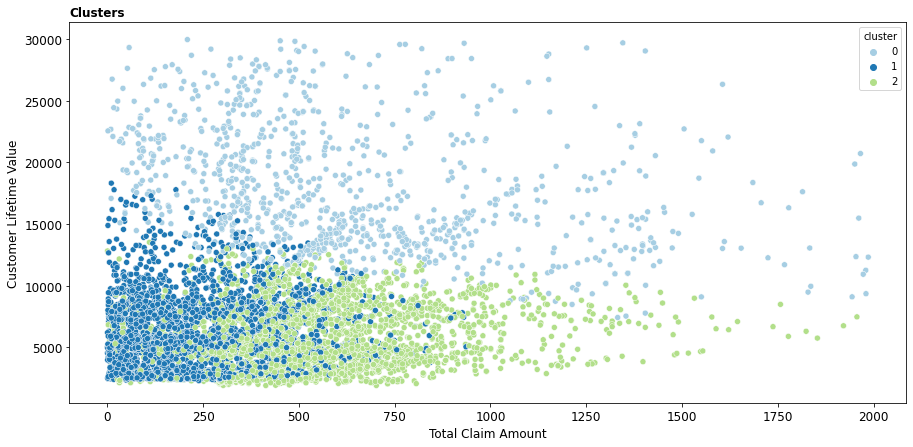

In [70]:
table = engage_clustered
x = "Total Claim Amount"
y = "Customer Lifetime Value"
hue = "cluster"

plot2d(table,x,y,hue)

<ipython-input-71-d5b28507ef17>:7: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  donut = engage_clustered.groupby(['cluster'])['Customer Lifetime Value','Income','Total Claim Amount'].mean().values


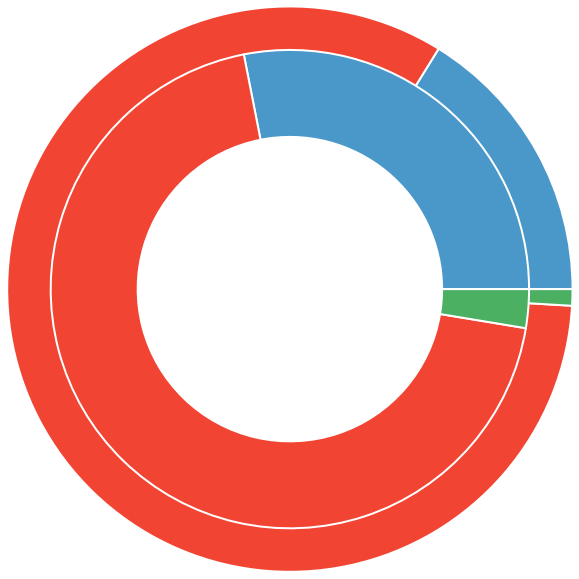

In [71]:
#################################################################################################################################################
# DONUT
plt.style.use('seaborn-white')

names = ['Customer Lifetime Value','Income','Total Claim Amount']
pop_avg = engage_clustered[['Customer Lifetime Value','Income','Total Claim Amount']].describe()[1:2].values[0]
donut = engage_clustered.groupby(['cluster'])['Customer Lifetime Value','Income','Total Claim Amount'].mean().values

# 0 -> Health
# 1 -> Motor
# 2 -> Generic

donut_plt(names =names ,pop = pop_avg,table = donut,nrow = 2)

#################################################################################################################################################

In [72]:
df["High_Educ"]=1.
df_outliers["High_Educ"] = 1.

df.loc[(df.Education == 'College') | (df.Education == 'High School or Below'), "High_Educ"] = 0.
df_outliers.loc[(df_outliers.Education == 'College') | (df_outliers.Education == 'High School or Below'), "High_Educ"] = 0.



In [73]:
df = df.rename(columns={'Marital Status':'MaritalStatus'})

In [74]:
df_outliers = df_outliers.rename(columns={'Marital Status':'MaritalStatus'})

In [75]:
df["Married"]=0.
df_outliers["Married"] = 0.

df.loc[(df.MaritalStatus == 'Married'), "Married"] = 1.
df_outliers.loc[(df_outliers.MaritalStatus == 'Married'), "Married"] = 1.

In [76]:
df = df.rename(columns={'Location Code':'LocationCode'})
df_outliers = df_outliers.rename(columns={'Location Code':'LocationCode'})

In [77]:
df["City"]=0.
df_outliers["City"] = 0.

df.loc[(df.LocationCode == 'Urban'), "City"] = 1.
df_outliers.loc[(df_outliers.LocationCode == 'Urban'), "City"] = 1.

In [78]:
df["employed"]=0.
df_outliers["employed"] = 0.

df.loc[(df.EmploymentStatus == 'Employed'), "employed"] = 1.
df_outliers.loc[(df_outliers.EmploymentStatus == 'Employed'), "employed"] = 1.

In [79]:
df.City

0       0.0
1       0.0
2       0.0
3       0.0
4       0.0
       ... 
9129    1.0
9130    0.0
9131    0.0
9132    0.0
9133    0.0
Name: City, Length: 8929, dtype: float64

Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 1, iteration: 1/100, moves: 0, cost: 11310.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 2, iteration: 1/100, moves: 581, cost: 10284.0
Run 2, iteration: 2/100, moves: 0, cost: 10284.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 3, iteration: 1/100, moves: 2278, cost: 8898.0
Run 3, iteration: 2/100, moves: 261, cost: 8898.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 4, iteration: 1/100, moves: 0, cost: 11748.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 5, iteration: 1/100, moves: 121, cost: 11959.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 6, iteration: 1/100, moves: 0, cost: 11389.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 7, iteration: 1/100, moves: 1534, cos

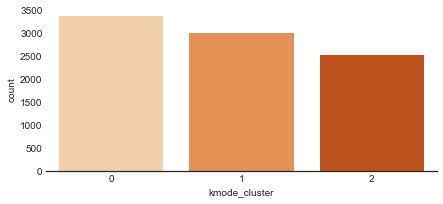

  High_Educ Gender City Married employed
0       1.0      F  0.0     1.0      1.0
1       0.0      F  0.0     1.0      1.0
2       0.0      M  0.0     0.0      0.0


In [90]:
per = df[['Customer',"High_Educ","Gender","City","Married", "employed"]]
my_modes = per[["High_Educ","Gender","City","Married", "employed"]].astype(str)

k = 3

km = KModes(n_clusters=k,
            init='Huang', 
            n_init=15, 
            verbose=1)


clusters = km.fit_predict(my_modes)

ktest= per.copy()
ktest["kmode_cluster"]=clusters

# Cluster frequency


cluster_freq(ktest,'kmode_cluster')


# Print the cluster centroids

k_modes = pd.DataFrame(km.cluster_centroids_, columns = ["High_Educ","Gender","City","Married", "employed"])
print(k_modes)


kmo = pd.DataFrame(ktest.kmode_cluster)



In [91]:
k_modes.to_csv("clu2.csv")

In [92]:
kmo.to_csv("kmodes.csv")

engage_cluster
high value    1173
low value     3995
wealthy       3761
dtype: int64
engage_cluster  kmode_cluster  
high value      high-edu female     384
                working female      419
                young male          345
low value       high-edu female     844
                working female     1253
                young male         1805
wealthy         high-edu female    1718
                working female     1642
                young male          321
dtype: int64
  engage_cluster    kmode_cluster  count  to_divide  kmode_freq
0     high value  high-edu female    384       1173        32.7
1     high value   working female    419       1173        35.7
2     high value       young male    345       1173        29.4
3      low value  high-edu female    844       3995        21.1
4      low value   working female   1253       3995        31.4
5      low value       young male   1805       3995        45.2
6        wealthy  high-edu female   1718       3761        45.

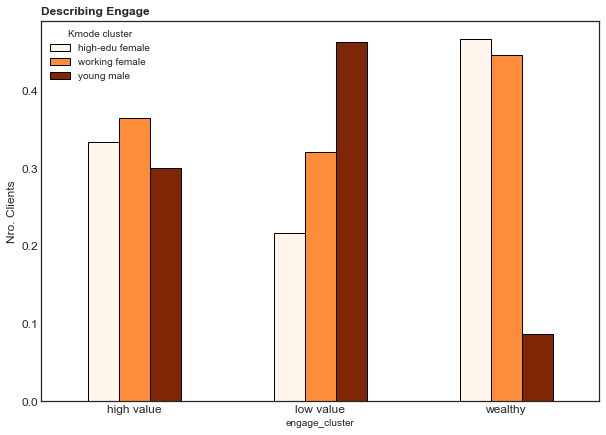

In [102]:
df1 = pd.DataFrame(columns=["Customer"])
df1.Customer = per.Customer
#df.set_index("c_id",drop=True,inplace=True)

#kmode_label = pd.read_csv('/Users/Manita/OneDrive - NOVAIMS/DM/project/3_engage/kmodes.csv',sep=',')
kmode_label = pd.read_csv('kmodes.csv',sep=',')
df1['kmode_cluster']=kmode_label.kmode_cluster

df1 = pd.concat([df1,engage_clustered.cluster],axis=1)
df1.columns = ["Customer","kmode_cluster","engage_cluster"]

#teste = engage[['Child','High_Educ','Living_Area']]

#teste['kmode'] = df.kmode_cluster

#teste.groupby(['kmode']).apply(pd.DataFrame.mode).reset_index(drop=True)


# give names to clusters

# engage
df1['engage_cluster'].replace(to_replace=0, value='high value', inplace=True)
df1['engage_cluster'].replace(to_replace=1, value='wealthy', inplace=True)
df1['engage_cluster'].replace(to_replace=2, value='low value', inplace=True)

# kmodes
df1['kmode_cluster'].replace(to_replace=1, value='high-edu female', inplace=True)
df1['kmode_cluster'].replace(to_replace=0, value='working female', inplace=True)
df1['kmode_cluster'].replace(to_replace=2, value='young male', inplace=True)



print(df1.groupby(['engage_cluster']).size())
print(df1.groupby(['engage_cluster','kmode_cluster']).size())


c1 = pd.DataFrame({'count' : df1.groupby( [ "engage_cluster"] ).size()}).reset_index()
c2 = pd.DataFrame({'count' : df1.groupby( [ "engage_cluster", "kmode_cluster"] ).size()}).reset_index()

c1_count = c1['count'].values

    
to_divide = pd.DataFrame({'to_divide':np.column_stack((c1_count, c1_count,c1_count)).flatten()})


c2 = pd.concat([c2,to_divide],axis=1)


# table with percentage of each k mode cluster in engage clusters
c2['kmode_freq'] = np.round(np.divide(c2['count'].values,c2.to_divide)*100,decimals = 1)

print(c2)



crosstable =pd.crosstab(df1['engage_cluster'], df1['kmode_cluster']).apply(lambda r: r/r.sum(), axis=1)

crosstable.plot.bar(figsize=(10, 7),colormap="Oranges",edgecolor = "black",linewidth = 1,rot=0)
#plt.legend() -> array com nomes dos clusters
plt.legend(title = "Kmode cluster",loc = 0)
plt.title ("Describing Engage", loc = "left",fontweight = "bold")
plt.ylabel("Nro. Clients", fontsize = 12)
plt.tick_params(labelsize=12)
plt.savefig('clustering.svg', bbox_inches='tight')
plt.show()

In [95]:
c2.to_csv("clu3.csv")

In [303]:
c2

,engage_cluster,kmode_cluster,count,to_divide,kmode_freq
0,high,f,384,1173,32.7
1,high,h,419,1173,35.7
2,high,m,345,1173,29.4
3,low,f,844,3995,21.1
4,low,h,1253,3995,31.4
5,low,m,1805,3995,45.2
6,wea,f,1718,3761,45.7
7,wea,h,1642,3761,43.7
8,wea,m,321,3761,8.5
